In [1]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 144793 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.23-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.23-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.23-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope

In [2]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import h5py
import numpy as np
from keras.utils import np_utils
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tqdm import tqdm
import os
import cv2

In [5]:
def load_model(weights_name):
    vgg = VGG19(weights = 'imagenet', include_top = False, input_shape = (224, 224, 3))
    for layer in vgg.layers:
        layer.trainable = False
    model = Sequential()
    model.add(vgg)
    model.add(Flatten())
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    model.load_weights('/content/drive/My Drive/'+ weights_name)
    return model

In [6]:
M_model = load_model('weights_weights_NM.h5')
H_model = load_model('weights_weights_NH.h5')
C_model = load_model('weights_weights_NC.h5')
A_model = load_model('weights_weights_NA.h5')
G_model = load_model('weights_weights_NG.h5')
D_model = load_model('weights_weights_ND.h5')

80142336/80134624 [==============================] - 1s 0us/step


In [7]:
def MODEL(image):
    M_score = M_model.predict(image)
    if M_score[0][0] > 0.5:
        res = 'M'
    else:
        C_score = C_model.predict(image)
        if C_score[0][0] > 0.5:
            res = 'C'
        else:
            H_score = H_model.predict(image)
            if H_score[0][0] > 0.5:
                res = 'H'
            else:
                A_score = A_model.predict(image)
                if A_score[0][0] > 0.5:
                    res = 'A'
                else:
                    G_score = G_model.predict(image)
                    if G_score[0][0] > 0.5:
                        res = 'G'
                    else:
                        D_score = D_model.predict(image)
                        if D_score[0][0] > 0.5:
                            res = 'D'
                        else:
                            res = 'N'
    return res

In [8]:
file = h5py.File('/content/drive/My Drive/aug_dataset.hdf5','r')

In [9]:
N_dataset_x_test = file['N_dataset_x_test'][:]
N_dataset_x_test = N_dataset_x_test[:100]
D_dataset_x_test = file['D_dataset_x_test'][:]
D_dataset_x_test = D_dataset_x_test[:100]
G_dataset_x_test = file['G_dataset_x_test'][:]
G_dataset_x_test = G_dataset_x_test[:100]
C_dataset_x_test = file['C_dataset_x_test'][:]
C_dataset_x_test = C_dataset_x_test[:100]
A_dataset_x_test = file['A_dataset_x_test'][:]
A_dataset_x_test = A_dataset_x_test[:100]
H_dataset_x_test = file['H_dataset_x_test'][:]
H_dataset_x_test = H_dataset_x_test[:100]
M_dataset_x_test = file['M_dataset_x_test'][:]
M_dataset_x_test = M_dataset_x_test[:100]
x_test = np.concatenate((N_dataset_x_test,D_dataset_x_test,G_dataset_x_test,C_dataset_x_test,A_dataset_x_test,H_dataset_x_test,M_dataset_x_test))

In [10]:
print('N has %d images for testing' % len(N_dataset_x_test))
print('D has %d images for testing' % len(D_dataset_x_test))
print('G has %d images for testing' % len(G_dataset_x_test))
print('C has %d images for testing' % len(C_dataset_x_test))
print('A has %d images for testing' % len(A_dataset_x_test))
print('H has %d images for testing' % len(H_dataset_x_test))
print('M has %d images for testing' % len(M_dataset_x_test))
print('we have %d images for testing' % len(x_test))

N has 100 images for testing
D has 100 images for testing
G has 100 images for testing
C has 100 images for testing
A has 100 images for testing
H has 100 images for testing
M has 100 images for testing
we have 700 images for testing


In [11]:
truth = ['N'] * len(N_dataset_x_test) + ['D'] * len(D_dataset_x_test) + ['G'] * len(G_dataset_x_test) + ['C'] * len(C_dataset_x_test)+['A'] * len(A_dataset_x_test) + ['H'] * len(H_dataset_x_test) + ['M'] * len(M_dataset_x_test)

In [12]:
len(truth)

700

In [13]:
pred_res = []
for image in tqdm(x_test):
    image = image.astype('float32')
    image/=255
    image = np.expand_dims(image, axis=0)
    res = MODEL(image)
    pred_res.append(res)

  0%|          | 0/700 [00:00<?, ?it/s]

100%|██████████| 700/700 [02:18<00:00,  5.04it/s]


In [14]:
counter = 0
for pred, fact in zip(pred_res,truth):
    if pred == fact:
        counter += 1
print('test %d images'%len(truth))
print('correctly predict %d images' % counter)
print('accuracy is %f' %(counter/len(truth)))

test 700 images
correctly predict 584 images
accuracy is 0.834286


In [15]:
counter = 0
len_lst = [len(N_dataset_x_test),len(D_dataset_x_test),len(G_dataset_x_test),len(C_dataset_x_test),len(A_dataset_x_test),len(H_dataset_x_test),len(M_dataset_x_test)]
name_lst = ['N','D','G','C','A','H','M']
last_len = 0
for length, name in zip(len_lst,name_lst):
    counter = 0
    for a,b in zip(pred_res[last_len:last_len+length],truth[last_len:last_len+length]):
        if a == b:
            counter += 1
    last_len += length
    print(name + ' accuracy is ' + str(counter/length))

N accuracy is 0.57
D accuracy is 0.84
G accuracy is 0.88
C accuracy is 0.91
A accuracy is 0.84
H accuracy is 0.85
M accuracy is 0.95


In [16]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

In [17]:
accuracy_score(pred_res,truth)
print(classification_report(pred_res,truth))

              precision    recall  f1-score   support

           A       0.84      0.87      0.85        97
           C       0.91      0.93      0.92        98
           D       0.84      0.68      0.75       124
           G       0.88      0.85      0.87       103
           H       0.85      0.91      0.88        93
           M       0.95      0.95      0.95       100
           N       0.57      0.67      0.62        85

    accuracy                           0.83       700
   macro avg       0.83      0.84      0.83       700
weighted avg       0.84      0.83      0.83       700



In [33]:
y_score = []
y_true = []
for i in range(len(pred_res)):
  if pred_res[i] == 'N': y_score.append(1)
  elif pred_res[i] == 'D': y_score.append(2)
  elif pred_res[i] == 'G': y_score.append(3)
  elif pred_res[i] == 'C': y_score.append(4)
  elif pred_res[i] == 'A': y_score.append(5)
  elif pred_res[i] == 'H': y_score.append(6)
  else: y_score.append(7)
for i in range(len(truth)):
  if truth[i] == 'N': y_true.append(1)
  elif truth[i] == 'D': y_true.append(2)
  elif truth[i] == 'G': y_true.append(3)
  elif truth[i] == 'C': y_true.append(4)
  elif truth[i] == 'A': y_true.append(5)
  elif truth[i] == 'H': y_true.append(6)
  else: y_true.append(7)

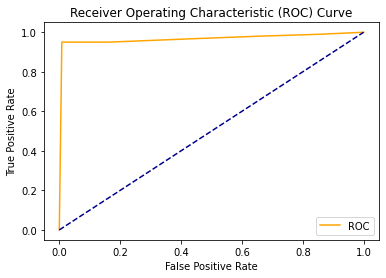

In [35]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()
fpr, tpr, thresholds = roc_curve(y_true, y_score,pos_label = 7)
plot_roc_curve(fpr, tpr)